In [92]:
import numpy as np
import tweepy as tw
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import csv

In [93]:


def loadDataset(file):
    with open(file, newline='\n') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        data = []
        for row in spamreader:
            dataPoint = (row[0], float(row[1]))
            data.append(dataPoint)
        return data

In [94]:
#To run this function access to the Twitter API is needed
#Info can be found here: https://developer.twitter.com/en/docs

#@params:
    #num_tweets: Int number of tweets to scrape.
    #sarcastic: String which defines the "sarcastic" query.
    #serious: String which defines the "serious" query.
    #API_key: Twitter api key.
    #API_secret_key: Twitter secret api key.

#@return:
    #data: List of tuples of the form (text, label) where text is some tweet and
        #label is 1.0 or -1.0 depending on the tweets hashtag.
        
def scrape(num_tweets, sarcastic, serious, API_key, API_secret_key):
        
    data=[]
    
    auth = tw.AppAuthHandler(API_key, API_secret_key)
    api = tw.API(auth)

    sarc_tweets = tw.Cursor(api.search, q=sarcastic, lang="en", tweet_mode='extended').items(num_tweets)
    for tweet in sarc_tweets:
        t1 = tweet.full_text
        t1 = t1.lower()
        t1 = t1.replace('#sarcasm', '')
        t1 = t1.replace('#irony', '')
        t = (t1, 1.0)
        data.append(t)


    ser_tweets = tw.Cursor(api.search, q=serious, lang="en", tweet_mode='extended').items(num_tweets)
    for tweet in ser_tweets:
        t1 = tweet.full_text
        t1 = t1.lower()
        t1 = t1.replace('#serious', '')
        t1 = t1.replace('#happy', '')
        t = (t1, 0.0)
        data.append(t)
    
    return data

In [95]:
#@params:
    #data: List of tuples of the form (text, label) where text is some tweet and 
        #label is 1.0 or -1.0 depending on the tweets hashtag.
    #lc: Boolean where true to lowercases the text and false does not.
    #punc: Boolean where true removes punctuation and false does not.
    #w: Float value given to labels (EX: -1.0, 1.0).
    #n_gram: Integer that determines n_gram mode. If n_gram is 0, then tokens are generated 
        #by whitespace. If n_gram > 0, tokens are n_grams of length n_gram. For example,
        #if n_gram = 2, the tokenizer will generate bigram tokens.
    #stop_words: List of stop_words to be removed from the text. Only works in n_gram = 0 mode.

#@return:
    #XY: XY is a list with 2 entries
    #XY[0]=X is nxm matrix where n = |tweets| and m = |vocab|. Each entry in X is a feature 
        #vector for a tweet.
    #XY[1]=Y is nX1 matrix. Each entry in Y is a label for a tweet.
    
def tokenizer(data, lc, punc, w, n_gram, stop_words):
    XY = []
    X = []
    Y = []
    vocab = {}  
    tweet_list = []
    for tweet in data:
        if(tweet[1] == -1.0):
            weight = w * -1.0
        else:
            weight = w
        text_list = []
        text = tweet[0]
        Y.append(tweet[1])
        if(lc):
            text = text.lower()
            
        if(punc):
            text = text.translate({ord(i): None for i in '.!@#$%^&*();:<,>?/{}[]\|=+-_~'})   
        
        if(n_gram == 0):
            text_list = text.split()
            for word in text_list:
                
                if(word in stop_words):
                    text_list.remove(word)
                    
                elif(word not in vocab):
                    vocab[word] = weight
                else:
                    vocab[word] = vocab[word] + weight
        elif(n_gram > 0):
            token = ""
            for i in range(0, len(text)):
                if((i + n_gram) < len(text)):
                    for j in range(0, n_gram):
                        token = token + text[i+j]
                text_list.append(token)
                if(token not in vocab):
                        vocab[token] = weight
                else:
                        vocab[token] = vocab[token] + weight
                token = ""
        tweet_list.append(text_list)
    vocab_list = []
    for token in vocab:
        vocab_list.append(token)
    for tweet in tweet_list:
        vect = []
        for word in vocab_list:
            vect.append(word)
        for i in range(0, len(vect)):
            if(vect[i] in tweet):
                vect[i] = vocab[token]
            else:
                vect[i] = 0.0
        X.append(vect)
        
    XY.append(X)
    XY.append(Y)
    return XY

In [96]:
#@params:
    #X_test: Array of test vectors for X
    #y_test: Vector of labels for X_test

#@return:
    #stats: List of values where:
        #stats[0] = accuracy
        #stats[1] = recall
        #stats[2] = precision
        #stats[3] = f1_score
        
def get_stats(X_test, y_test, logreg):
    
    stats = []
    
    sim = logreg.predict(X_test)

    total = len(y_test)
    false_pos = 0.0
    false_neg = 0.0
    true_pos = 0.0
    true_neg = 0.0

    for i in range(0, total):
        if y_test[i] != sim[i]:
            if y_test[i] == 1.0:
                false_neg+=1.0
            else:
                false_pos+=1.0
        else:
            if y_test[i] == 1.0:
                true_pos+=1.0
            else:
                true_neg+=1.0

    accuracy = (true_pos + true_neg) / float(total)
    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    f1_score = (2 * precision * recall) / (precision + recall)

    stats.append(accuracy)
    stats.append(recall)
    stats.append(precision)
    stats.append(f1_score)
    
    return stats


In [77]:
sarcastic="#irony OR #sarcasm -filter:retweets"
serious="#serious OR #happy -filter:retweets"
API_key='FefcgZBtr06cMxhLaEaBmyYQu'
API_secret_key='UvYiZll4VvTuacUHpTEfYe2HqCKHkOfL8zo8HITClNwoaTcprt'
dataset1 = scrape(1000, sarcastic, serious, API_key, API_secret_key)
print(len(dataset1))

2000


In [26]:
A=[]
R=[]
P=[]
F=[]
runs = 50
for i in range(0, runs):
    print(i)
    sw=""
    XY= tokenizer(data, True, True, 1, 0, sw)
    X=XY[0]
    y=XY[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(X_train, y_train)
    stats = get_stats(X_test, y_test)
    A.append(stats[0])
    R.append(stats[1])
    P.append(stats[2])
    F.append(stats[3])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


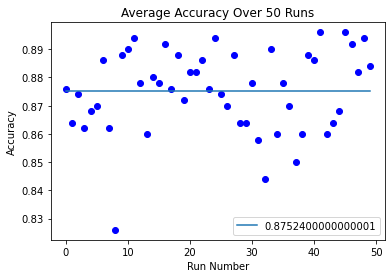

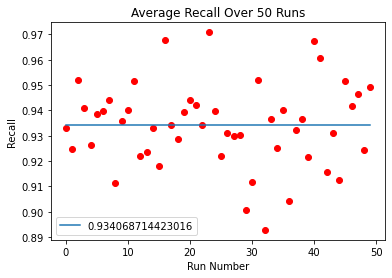

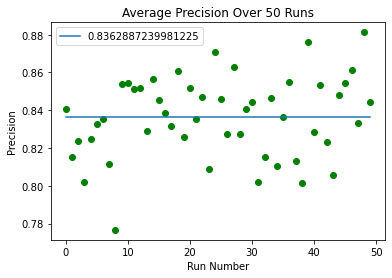

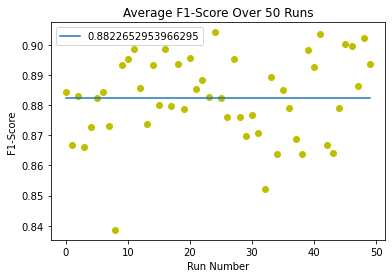

In [33]:
runs = 50
a=0
r=0
p=0
f=0
for i in range(0, runs):
    a = a + A[i]
    r = r + R[i]
    p = p + P[i]
    f = f + F[i]

a = a/runs
r = r/runs
p = p/runs
f = f/runs

Af = []
Rf = []
Pf = []
Ff = []
for i in range(0, runs):
    Af.append(a)
    Rf.append(r)
    Pf.append(p)
    Ff.append(f)
print("\n\n\n\n")
x = range(0, runs)
plt.figure(0)
plt.plot(x, A, 'bo')
plt.plot(x, Af, label=a)
plt.legend()
plt.xlabel("Run Number")
plt.ylabel("Accuracy")
plt.title("Average Accuracy Over 50 Runs")
print("\n\n\n\n")
plt.figure(1)
plt.plot(x, R, 'ro')
plt.plot(x, Rf, label=r)
plt.legend()
plt.xlabel("Run Number")
plt.ylabel("Recall")
plt.title("Average Recall Over 50 Runs")
print("\n\n\n\n")
plt.figure(2)
plt.plot(x, P, 'go')
plt.plot(x, Pf, label=p)
plt.legend()
plt.xlabel("Run Number")
plt.ylabel("Precision")
plt.title("Average Precision Over 50 Runs")
print("\n\n\n\n")
plt.figure(3)
plt.plot(x, F, 'yo')
plt.plot(x, Ff, label=f)
plt.legend()
plt.xlabel("Run Number")
plt.ylabel("F1-Score")
plt.title("Average F1-Score Over 50 Runs")
print("\n\n\n\n")


In [115]:
dataset2 = loadDataset("Dataset 2.csv")
dataset3 = loadDataset("dataset 3.csv")
final_data = []
final_data = dataset1 + dataset2 + dataset3
sw0=[]
sw1= ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
XY= tokenizer(final_data, True, True, 1, 0, sw1)

In [116]:
X=XY[0]
y=XY[1]


X_train_f = []
y_train_f =[]
X_test_f = []
y_test_f = []

for i in range(0, len(final_data)):
    if i<2250:
        X_train_f.append(X[i])
        y_train_f.append(y[i])
    else:
        X_test_f.append(X[i])
        y_test_f.append(y[i])
        
print(len(X_train_f), len(y_train_f), len(X_test_f), len(y_test_f))

2250 2250 250 250


In [117]:
logreg_final = LogisticRegression(max_iter=10000)
logreg_final.fit(X_train_f, y_train_f)
stats_final = get_stats(X_test_f, y_test_f, logreg_final)

In [118]:
print(stats_final)

[0.692, 0.8985507246376812, 0.4696969696969697, 0.6169154228855721]


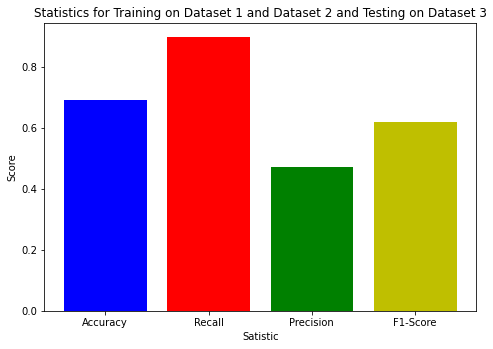

In [136]:
fig4 = plt.figure()
ax = fig4.add_axes([0,0,1,1])
ax.bar('Accuracy', stats_final[0], color='b')
ax.bar('Recall', stats_final[1], color='r')
ax.bar('Precision', stats_final[2], color='g')
ax.bar('F1-Score', stats_final[3], color='y')
plt.xlabel("Satistic")
plt.ylabel("Score")
plt.title("Statistics for Training on Dataset 1 and Dataset 2 and Testing on Dataset 3")

plt.show()